**In this notebook, we examine using SVD to formulate the collaborative filtering recommender algorithm**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
%matplotlib inline  

from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model
import os
import urllib.parse
import re
import pathlib

from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, SVD, SVDpp, SlopeOne, NMF, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, CoClustering

from surprise.similarities import cosine, msd, pearson

from surprise import accuracy 
from surprise import Reader
from surprise import Dataset
from surprise import dataset
from surprise import dump
from collections import defaultdict
from surprise.model_selection import train_test_split, KFold, GridSearchCV, cross_validate

import random
import timeit
import pickle


import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 500
pd.options.display.max_rows = 200

## 1. Import datasets

In [2]:
df_anime = pd.read_csv('processed_data/processed_anime.csv')
df_reviews = pd.read_csv('processed_data/processed_reviews.csv')

In [3]:
df_anime.head()

,index,Unnamed: 0,Unnamed: 0.1,Title,URL,English,Synonyms,Japanese,Type,Episodes,Status,Aired,Premiered,Broadcast,Producers,Licensors,Studios,Source,Genres,Duration,Rating,Score,Ranked,Popularity,Members,Favorites,Started,Ended,Voters,Adaptation,Alternative version,Side story,Spin-off,Synopsis,Prequel,Alternative setting,Sequel,Other,Summary,Character,Parent story,Full story,Genre_0,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7,Genre_8,Genre_9,Genre_10,Genre_11,Genre_12,Air_Start,Air_End,Duration_Aired,Producer_0,Producer_1,Producer_2,Producer_3,Producer_4,Producer_5,Producer_6,Producer_7,Producer_8,Producer_9,Producer_10,Producer_11,Producer_12,Producer_13,Producer_14,Producer_15,Producer_16,Producer_17,Producer_18,Producer_19,Studio_0,Studio_1,Studio_2,Studio_3,Studio_4,Studio_5,Studio_6,Anime_Number,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Topic_Category,anime_uid
0,0,0,0,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_A...,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi: Fullmetal Alchemist,...",鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,Finished Airing,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,Sundays at 17:00 (JST),"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",['Bones'],Manga,"['Action', 'Military', 'Adventure', 'Comedy', ...",24,R - 17+ (violence & profanity),9.21,#1,#3,2188557,178710,2009-04-05,2009-04-05,1325568.0,['Fullmetal Alchemist'],['Fullmetal Alchemist'],"['Fullmetal Alchemist: Brotherhood Specials', ...",['Fullmetal Alchemist: Brotherhood - 4-Koma Th...,"""In order for something to be obtained, someth...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Action,Military,Adventure,Comedy,Drama,Magic,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN,2009-04-05,2010-07-04,1.25,Aniplex,Square Enix,Mainichi Broadcasting System,Studio Moriken,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bones,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.2993,"world, human, power, earth, fight, save, war, ...",in order for something to be obtained somethi...,Anime about war or battles on earth,5114
1,1,1,1,Shingeki no Kyojin: The Final Season,https://myanimelist.net/anime/40028/Shingeki_n...,Attack on Titan Final Season,"Shingeki no Kyojin Season 4, Attack on Titan S...",進撃の巨人 The Final Season,TV,16.0,Currently Airing,"Dec 7, 2020 to ?",Winter 2021,Mondays at 00:10 (JST),"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],['MAPPA'],Manga,"['Action', 'Military', 'Mystery', 'Super Power...",23,R - 17+ (violence & profanity),9.20,#2,#160,619515,31721,2020-12-07,2020-12-07,207859.0,['Shingeki no Kyojin'],NaN,NaN,NaN,Gabi Braun and Falco Grice have been training ...,['Shingeki no Kyojin Season 3 Part 2'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Action,Military,Mystery,Super Power,Drama,Fantasy,Shounen,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-07,NaN,NaN,Production I.G,Dentsu,Mainichi Broadcasting System,Pony Canyon,Kodansha,Techno Sound,Pony Canyon Enterprise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAPPA,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0.2820,"world, human, power, earth, fight, save, war, ...",gabi braun and falco grice have been training ...,Anime about war or battles on earth,40028
2,2,2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,Steins;Gate,NaN,STEINS;GATE,TV,24.0,Finished Airing,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,Wednesdays at 02:05 (JST),"['Frontier Works', 'Media Factory', 'Movic', '...",['Funimation'],['White Fox'],Visual novel,"['Thriller', 'Sci-Fi']",24,PG-13 - Teens 13 or older,9.12,#3,#9,1747892,147016,2011-04-06,2011-04-06,941172.0,['Steins;Gate'],['Steins;Gate: Kyoukaimenjou no Missing Link -...,NaN,NaN,The self-proclaimed mad scientist Rintarou Oka...,NaN,"['ChäoS;HEAd', 'Robotics;Notes', 'ChäoS;Child'...",['Steins;Gate: Oukoubakko no Poriomania'],['Steins;Gate: Soumei Eichi no Cognitive Compu...,NaN,NaN,NaN,NaN,Thriller,Sci-Fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-04-06,2011-09-14,0.44,Frontier Works,Media Factory,Movic

In [4]:
df_reviews.head()

,uid,profile,anime_uid,text,score,scores,link
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664
3,8254,edgewalker00,2904,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254
4,10046,eneri,2904,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '9', 'Animation': '...",https://myanimelist.net/reviews.php?id=10046


In [5]:
print(df_anime.shape)
print(df_reviews.shape)

(4808, 92)
(75921, 7)


## 2. Merge Reivews and Animes Datasets

In [6]:
# create a userid for each profile
user_id_profile = df_reviews.drop_duplicates(['profile'])
user_id_profile['user_id'] = user_id_profile.index
user_id_profile.shape

(15363, 8)

In [7]:
#subset the anime dataset for merging
df_anime_final = df_anime[['anime_uid','Title','Episodes','Genres','Score','Ranked','Popularity','Members','Favorites']]

In [8]:
# merge user_id_profile with df_reviews to get user_id
df_reviews = df_reviews.merge(user_id_profile[['profile', 'user_id']], how='left', on='profile')
df_reviews.shape

(75921, 8)

In [9]:
# check merged data
df_reviews[df_reviews['profile']=='DesolatePsyche'].head(5)

,uid,profile,anime_uid,text,score,scores,link,user_id
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938,0
1366,255793,DesolatePsyche,12403,\n \n \n \n ...,6,"{'Overall': '6', 'Story': '6', 'Animation': '9...",https://myanimelist.net/reviews.php?id=255793,0
2079,298207,DesolatePsyche,35073,\n \n \n \n ...,6,"{'Overall': '6', 'Story': '6', 'Animation': '8...",https://myanimelist.net/reviews.php?id=298207,0
2779,291256,DesolatePsyche,2035,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '9', 'Animation': '7...",https://myanimelist.net/reviews.php?id=291256,0
4547,255881,DesolatePsyche,30279,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255881,0


In [10]:
#rename columns for merging
df_anime_final = df_anime_final.rename(columns={'Score': 'Average_rating'})
df_reviews = df_reviews.rename(columns={'score': 'User_rating'})

In [11]:
#merge the 2 dfs
df_merge = pd.merge(df_anime_final, df_reviews , on = 'anime_uid', how='inner')
df_merge.head()

,anime_uid,Title,Episodes,Genres,Average_rating,Ranked,Popularity,Members,Favorites,uid,profile,text,User_rating,scores,link,user_id
0,5114,Fullmetal Alchemist: Brotherhood,64.0,"['Action', 'Military', 'Adventure', 'Comedy', ...",9.21,#1,#3,2188557,178710,210404,12sed,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=210404,11
1,5114,Fullmetal Alchemist: Brotherhood,64.0,"['Action', 'Military', 'Adventure', 'Comedy', ...",9.21,#1,#3,2188557,178710,203544,For_Reign,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=203544,1147
2,5114,Fullmetal Alchemist: Brotherhood,64.0,"['Action', 'Military', 'Adventure', 'Comedy', ...",9.21,#1,#3,2188557,178710,29856,appleaday,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=29856,1906
3,5114,Fullmetal Alchemist: Brotherhood,64.0,"['Action', 'Military', 'Adventure', 'Comedy', ...",9.21,#1,#3,2188557,178710,138419,RoyRiza89,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=138419,1907
4,5114,Fullmetal Alchemist: Brotherhood,64.0,"['Action', 'Military', 'Adventure', 'Comedy', ...",9.21,#1,#3,2188557,178710,14342,Ardinayka,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '5', 'Animation': '9...",https://myanimelist.net/reviews.php?id=14342,1908


In [12]:
df_merge.shape

(75921, 16)

In [13]:
#convert user rating values to integer and round 
#this has to be done because surprise does not take in float values
df_merge['User_rating'] = df_merge['User_rating'].astype(int)

df_merge['User_rating'] = df_merge['User_rating'].apply(round)


## 3. EDA

<AxesSubplot:>

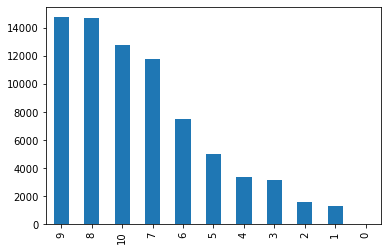

In [14]:
# plot distribution in matplotlib
userrating_count = pd.value_counts(df_merge['User_rating'].values, sort=True)

userrating_count.plot.bar()


In [15]:
#check number of user ratings per anime
anime_rating_counts = pd.DataFrame(df_merge.groupby(['anime_uid'])['User_rating'].count())

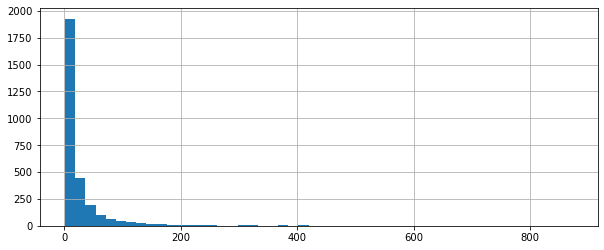

In [16]:
# Plot graph of number of user ratings
plt.figure(figsize = (10, 4))
anime_rating_counts['User_rating'].hist(bins = 50)
plt.show()

## 4. Apply Train Test Split

Apply the leave-one-out methodology to do train-test split. For each user, the most recent review is used as the test set. The most recent review is indicated by the largest uid. The reamining ratings would be used in the train dataset. This will help to ensure no data leakage.

In [19]:
try:
    os.mkdir('./processed_data/svd/')
except OSError:
    pass

In [20]:
# create test dataset
test = df_merge.loc[df_merge.groupby('user_id')['uid'].idxmax()]
test.shape

(15363, 16)

In [21]:
# create train dataset
train = df_merge[~(df_merge['uid'].isin(test['uid'].tolist()))]
train.shape

(60558, 16)

In [22]:
# get full data again by appending the test to the bottom of the train df
df_merge = pd.concat([train, test], axis=0)
df_merge.shape

(75921, 16)

## 5. Trying different algos with default parameters

**a. Train Test split to prevent data leakage**

In [22]:
#for surprise, it likes its data in a certain way and only that specific data
#create a data object first
data = df_merge[['user_id', 'anime_uid', 'User_rating']]
    
#create a reader object
reader = Reader(rating_scale=(0, 10))
    
#combine the data and reader objects to create a dataset object
anime_data = Dataset.load_from_df(data, reader)
raw_ratings = anime_data.raw_ratings

# Train data has 60558 records while test data has 15363 records
threshold = 60558 # don't change this, otherwise, risk data leakage
Train_raw_ratings = raw_ratings[:threshold]
Test_raw_ratings = raw_ratings[threshold:]

#data is now the train raw ratings
anime_data.raw_ratings = Train_raw_ratings

In [23]:
%%time
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), KNNBaseline(), KNNBasic(), KNNWithMeans(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, anime_data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Wall time: 1min 19s


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.872220,1.944002,0.127443
SVDpp,1.899217,9.486644,0.389334
KNNBaseline,1.999327,2.668387,1.363279
CoClustering,2.093930,1.435732,0.070727
KNNWithMeans,2.182250,2.750868,1.246070
KNNBasic,2.184682,2.605069,1.216711
SlopeOne,2.212660,0.213517,0.217353


#### since SVD and SVDpp have lower RMSE values, we will use these algos for prediction

## 6. SVD Model

**a. Perform Grid Search on Training Dataset**

In [24]:
%%time
#perform a gridsearch CV
kf_5 = KFold(n_splits=5,random_state=1)

params = {'n_factors':[5,10,100],'n_epochs': [5, 20], 'lr_all': [0.002, 0.02,0.2],
              'reg_all': [0.05, 0.5, 0.8],'verbose': [True],'random_state': [1]}


gridsearch_svd = GridSearchCV(SVD, param_grid=params, measures=['rmse','mae'], return_train_measures=True, cv=kf_5, n_jobs=1, joblib_verbose=3)

gridsearch_svd.fit(anime_data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing e

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.6min finished


In [25]:
print(gridsearch_svd.best_score)
print(gridsearch_svd.best_params)

{'rmse': 1.8251372422791448, 'mae': 1.3998815762681063}
{'rmse': {'n_factors': 5, 'n_epochs': 5, 'lr_all': 0.02, 'reg_all': 0.05, 'verbose': True, 'random_state': 1}, 'mae': {'n_factors': 5, 'n_epochs': 5, 'lr_all': 0.02, 'reg_all': 0.05, 'verbose': True, 'random_state': 1}}


**b. Perform Predictions on Test Dataset**

In [26]:
# use the best estimator based on rmse
algo = gridsearch_svd.best_estimator['rmse']

In [27]:
# retrain on the full train dataset
trainset = anime_data.build_full_trainset()
algo.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4


In [28]:
# Compute biased accuracy on Training Data                                               
testset = anime_data.construct_testset(Train_raw_ratings)                     
predictions = algo.test(testset)                                           
print('Accuracy on the Train Set:', accuracy.rmse(predictions))                                         

# Compute unbiased accuracy on Testing Data
testset = anime_data.construct_testset(Test_raw_ratings)  # testset is now the testing data
predictions = algo.test(testset)
print('Unbiased accuracy on Test Set,', accuracy.rmse(predictions))

RMSE: 1.6027
Accuracy on the Train Set: 1.602691655582138
RMSE: 1.9260
Unbiased accuracy on Test Set, 1.9259881197634696


In [29]:
# try sample predictions
user = 5
item = 100
algo.predict(user, item)

Prediction(uid=5, iid=100, r_ui=None, est=7.3599703576646425, details={'was_impossible': False})

In [30]:
# try sample predictions
user = 20
item = 300
algo.predict(user, item)

Prediction(uid=20, iid=300, r_ui=None, est=6.619173814004461, details={'was_impossible': False})

In [31]:
#save the model using Surprise's dump wrapper
try:
    os.mkdir('./processed_data/svd/')
except OSError:
    pass

dump.dump('processed_data/svd/SVD_model',predictions=predictions,algo=algo)

In [32]:
# reload model
# test_pred, algo = dump.load('SVD_model')

**c. Calculate Predictions on Randomly Sampled 100 unseen animes for each user**

In [33]:
# get unique user_id
user_ids = user_id_profile['user_id'].tolist()
len(user_ids)

15363

In [34]:
# get unique list of animes
anime_uid = list(set(df_merge['anime_uid'].tolist()))
len(anime_uid)

2913

In [39]:
# identify list of animes not watched. As the not watched list is huge, 
# we randomly sample 99 animes not watched items + the one watched item in the test data to form the not watched list

not_watched_list_1 = []
not_watched_list_2 = []
not_watched_list_3 = []
not_watched_list_4 = []
not_watched_list_5 = []

for user in user_ids:
    
    # subset watched animes - i.e. those with ratings
    u_watched = train[train['user_id']==user]['anime_uid'].tolist()
    
    # identify animes not watched i.e. those without ratings
    u_not_watched = list(set(anime_uid) - set(u_watched) - set(test[test['user_id']==user]['anime_uid'].tolist()))
    
    # set seed to control reproducibility of sampling
    random.seed(2345)
    u_not_watched_1 = random.sample(u_not_watched, 99) + test[test['user_id']==user]['anime_uid'].tolist()
    not_watched_list_1.append(u_not_watched_1)
        
    random.seed(2346)
    u_not_watched_2 = random.sample(u_not_watched, 99) + test[test['user_id']==user]['anime_uid'].tolist()
    not_watched_list_2.append(u_not_watched_2)
    
    random.seed(2347)
    u_not_watched_3 = random.sample(u_not_watched, 99) + test[test['user_id']==user]['anime_uid'].tolist()
    not_watched_list_3.append(u_not_watched_3)
    
    random.seed(2348)
    u_not_watched_4 = random.sample(u_not_watched, 99) + test[test['user_id']==user]['anime_uid'].tolist()
    not_watched_list_4.append(u_not_watched_4)
    
    random.seed(2349)
    u_not_watched_5 = random.sample(u_not_watched, 99) + test[test['user_id']==user]['anime_uid'].tolist()
    not_watched_list_5.append(u_not_watched_5)


In [40]:
# check len of watched_list and not watched list
print(len(not_watched_list_1))
print(len(not_watched_list_5))

15363
15363


In [41]:
# check 
print(len(not_watched_list_1[0]))
print(len(not_watched_list_5[0]))

100
100


In [42]:
# Create a function to compute the predicted ratings for not watched list for each user

def predict_ratings(model, profile, not_watched):
    
    '''
    Args:
        model - trained svd model
        profile - list of unique user ids
        not_watched - list of not watched animes for all users
    
    Returns:
        predicted_ratings - nested list of predicted ratings for each user

    '''
    
    # initialise list to store predictions
    predicted_rating = []
    
    for i in range(len(profile)):
        
        user = profile[i]
        
        # initialise list to store ratings for user
        individual_ratings = []
    
        # subset animes not watched for user
        animes = not_watched[i]
        #print(len(animes))
    
        # iterate through every anime not watched
        for k in animes:
            #print(k)
            pred = model.predict(user, k)
            individual_ratings.append(pred)
    
    
        #print(len(individual_ratings))
        predicted_rating.append(individual_ratings)
    
        #print('-------')       
    
    return predicted_rating


In [43]:
# Generate predict ratings based on the different sets of randomly sampled 100 not watched animes for each user

start_time = timeit.default_timer()

predicted_ratings_1 = predict_ratings(algo, user_ids, not_watched_list_1)
print('done')
predicted_ratings_2 = predict_ratings(algo, user_ids, not_watched_list_2)
print('done')
predicted_ratings_3 = predict_ratings(algo, user_ids, not_watched_list_3)
print('done')
predicted_ratings_4 = predict_ratings(algo, user_ids, not_watched_list_4)
print('done')
predicted_ratings_5 = predict_ratings(algo, user_ids, not_watched_list_5)
print('done')

elapsed = timeit.default_timer() - start_time
print('Time taken:', elapsed)

done
done
done
done
done
Time taken: 43.4279507


**d. Evaluate Hit Rate @ 10 for Proposed Recommender**

In [44]:
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
 
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
 
    return top_n

In [45]:
# sample to see the output of get_top_n
x = get_top_n(predicted_ratings_1[157], n=10)
x

defaultdict(list,
            {157: [(427, 9.146202738521765),
              (853, 8.816779934353674),
              (21939, 8.554972745439642),
              (15451, 8.533575237900171),
              (11665, 8.528052020104619),
              (10379, 8.514178861021223),
              (6594, 8.423781778191866),
              (10460, 8.373836314217753),
              (4725, 8.254012126491952),
              (477, 8.236413789268028)]})

In [46]:
# create function to evaluate hit rate @ 10

def hit_rate(predictions, test_dataset, profile):
    
    '''
    Args:
        predictions - nested list of predicted ratings of every user for the 100 animes randomly sampled
        test_dataset - test data
        profile - list of unique profiles
    
    Returns:
        hit_rate - hit rate @ 10
        top_10_animes - nested list of top 10 ainmes recommended for each user 
    '''
    
    top_10_animes = []
    hit = 0
    
    for i in range(len(predictions)):
    
        user = profile[i]
    
        # get the top 10 animes recommended to user
        top_10_animes = get_top_n(predictions[i], n=10)
    
        # check if the test data is found in the proposed top 10 recommended animes
        anime_watched = test_dataset[test_dataset['user_id']==user]['anime_uid']

        match = False
        for anime_uid, predictedRating in top_10_animes[int(user)]:
            if (int(anime_watched.values) == int(anime_uid)):
                    match = True
                    break
        if match :
            hit += 1
        else:
            hit = hit
    
    hit_rate = round((hit/len(profile))*100,2)
    
    return top_10_animes, hit_rate

In [47]:
# Generate hit rate @ 10 for the different samples

start_time = timeit.default_timer()

top_10_animes_1, hit_rate_1 = hit_rate(predicted_ratings_1, test, user_ids)
top_10_animes_2, hit_rate_2 = hit_rate(predicted_ratings_2, test, user_ids)
top_10_animes_3, hit_rate_3 = hit_rate(predicted_ratings_3, test, user_ids)
top_10_animes_4, hit_rate_4 = hit_rate(predicted_ratings_4, test, user_ids)
top_10_animes_5, hit_rate_5 = hit_rate(predicted_ratings_5, test, user_ids)

elapsed = timeit.default_timer() - start_time
print('Time taken:', elapsed)


Time taken: 51.275287299999945


In [48]:
# print hit rates
print('Hit Rate @ 10 based on not_watched_list_1: {}%'.format(hit_rate_1))
print('Hit Rate @ 10 based on not_watched_list_2: {}%'.format(hit_rate_2))
print('Hit Rate @ 10 based on not_watched_list_3: {}%'.format(hit_rate_3))
print('Hit Rate @ 10 based on not_watched_list_4: {}%'.format(hit_rate_4))
print('Hit Rate @ 10 based on not_watched_list_5: {}%'.format(hit_rate_5))


Hit Rate @ 10 based on not_watched_list_1: 30.55%
Hit Rate @ 10 based on not_watched_list_2: 25.22%
Hit Rate @ 10 based on not_watched_list_3: 27.64%
Hit Rate @ 10 based on not_watched_list_4: 27.84%
Hit Rate @ 10 based on not_watched_list_5: 34.39%


In [49]:
# print avg hit rates
avg_hit_rate = (hit_rate_1 + hit_rate_2 + hit_rate_3 + hit_rate_4 + hit_rate_5)/5 
print('Average Hit Rate @ 10 based on the 5 different sets of randomly sampled not watched list using SDV model: {}%'.format(avg_hit_rate))


The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
Average Hit Rate @ 10 based on the 5 different sets of randomly sampled not watched list using SDV model: 29.127999999999997%


In [51]:
# save the results
hit_rates_all = [hit_rate_1, hit_rate_2, hit_rate_3, hit_rate_4, hit_rate_5, avg_hit_rate]

with open("processed_data/svd/model3sdv_results.txt", "wb") as fp:   
    pickle.dump((predicted_ratings_1, predicted_ratings_2, predicted_ratings_3, predicted_ratings_4, predicted_ratings_5, \
                not_watched_list_1, not_watched_list_2, not_watched_list_3, not_watched_list_4, not_watched_list_5, \
                 top_10_animes_1, top_10_animes_2, top_10_animes_3, top_10_animes_4, top_10_animes_5, hit_rates_all, user_ids), fp)


In [52]:
# check some sample predictions
predicted_ratings_1[157]

[Prediction(uid=157, iid=23311, r_ui=None, est=7.808157316717633, details={'was_impossible': False}),
 Prediction(uid=157, iid=4936, r_ui=None, est=7.616599027857486, details={'was_impossible': False}),
 Prediction(uid=157, iid=4662, r_ui=None, est=7.549097425303591, details={'was_impossible': False}),
 Prediction(uid=157, iid=39198, r_ui=None, est=7.6347003443840045, details={'was_impossible': False}),
 Prediction(uid=157, iid=1325, r_ui=None, est=7.553076001836218, details={'was_impossible': False}),
 Prediction(uid=157, iid=274, r_ui=None, est=7.104357720094592, details={'was_impossible': False}),
 Prediction(uid=157, iid=2076, r_ui=None, est=7.802892980285975, details={'was_impossible': False}),
 Prediction(uid=157, iid=576, r_ui=None, est=6.9740771672756505, details={'was_impossible': False}),
 Prediction(uid=157, iid=3125, r_ui=None, est=7.43665881693838, details={'was_impossible': False}),
 Prediction(uid=157, iid=2885, r_ui=None, est=7.546883868885347, details={'was_impossible'

## 7. SVDpp Model

**a. Train Test Split to prevent data leakage and Grid Search**

In [53]:
#for surprise, it likes its data in a certain way and only that specific data
#create a data object first
data = df_merge[['user_id', 'anime_uid', 'User_rating']]
    
#create a reader object
reader = Reader(rating_scale=(0, 10))
    
#combine the data and reader objects to create a dataset object
anime_data = Dataset.load_from_df(data, reader)
raw_ratings = anime_data.raw_ratings

# Train data has 60558 records while test data has 15363 records
threshold = 60558 # don't change this, otherwise, risk data leakage
Train_raw_ratings = raw_ratings[:threshold]
Test_raw_ratings = raw_ratings[threshold:]

#data is now the train raw ratings
anime_data.raw_ratings = Train_raw_ratings

In [55]:
%%time
#perform a gridsearch CV
kf_5 = KFold(n_splits=5,random_state=1)

params = {'n_factors':[5,10,100],'n_epochs': [5, 20], 'lr_all': [0.002, 0.02,0.2],
              'reg_all': [0.05, 0.5, 0.8],'verbose': [True],'random_state': [1]}


gridsearch_svdpp = GridSearchCV(SVDpp, param_grid=params, measures=['rmse','mae'], return_train_measures=True, cv=kf_5)

gridsearch_svdpp.fit(anime_data)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4


In [56]:
print(gridsearch_svdpp.best_score)
print(gridsearch_svdpp.best_params)

{'rmse': 1.8211539990293253, 'mae': 1.3970198360054722}
{'rmse': {'n_factors': 5, 'n_epochs': 5, 'lr_all': 0.02, 'reg_all': 0.05, 'verbose': True, 'random_state': 1}, 'mae': {'n_factors': 5, 'n_epochs': 5, 'lr_all': 0.02, 'reg_all': 0.05, 'verbose': True, 'random_state': 1}}


**b. Perform Predictions on Test Dataset**

In [57]:
# use the best estimator based on rmse
algo2 = gridsearch_svdpp.best_estimator['rmse']

In [58]:
# retrain on the full train dataset
trainset2 = anime_data.build_full_trainset()
algo2.fit(trainset2)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4


In [59]:
# Compute biased accuracy on Training Data                                               
testset2 = anime_data.construct_testset(Train_raw_ratings)                     
predictions2 = algo2.test(testset2)                                           
print('Accuracy on the Train Set:', accuracy.rmse(predictions2))                                         

# Compute unbiased accuracy on Testing Data
testset2 = anime_data.construct_testset(Test_raw_ratings)  # testset is now the testing data
predictions2 = algo2.test(testset2)
print('Unbiased accuracy on Test Set,', accuracy.rmse(predictions2))

RMSE: 1.5504
Accuracy on the Train Set: 1.5503802306418946
RMSE: 1.9258
Unbiased accuracy on Test Set, 1.9257514830170968


In [60]:
# save model
dump.dump('processed_data/svd/SVDpp_model',predictions=predictions2,algo=algo2)

In [61]:
# # load model
# predictions2, algo2 = dump.load('processed_data/svd/SVDpp_model')

**c. Calculate Predictions on Randomly Sampled 100 unseen animes for each user**

In [62]:
# Generate predict ratings based on the different sets of randomly sampled 100 not watched animes for each user

start_time = timeit.default_timer()

predicted_ratings2_1 = predict_ratings(algo2, user_ids, not_watched_list_1)
print('done')
predicted_ratings2_2 = predict_ratings(algo2, user_ids, not_watched_list_2)
print('done')
predicted_ratings2_3 = predict_ratings(algo2, user_ids, not_watched_list_3)
print('done')
predicted_ratings2_4 = predict_ratings(algo2, user_ids, not_watched_list_4)
print('done')
predicted_ratings2_5 = predict_ratings(algo2, user_ids, not_watched_list_5)
print('done')

elapsed = timeit.default_timer() - start_time
print('Time taken:', elapsed)

done
done
done
done
done
Time taken: 96.69759060000024


**d. Evaluate Hit Rate @ 10 for Proposed Recommender**

In [63]:
# Generate hit rate @ 10 for the different samples

start_time = timeit.default_timer()

top_10_animes2_1, hit_rate2_1 = hit_rate(predicted_ratings2_1, test, user_ids)
top_10_animes2_2, hit_rate2_2 = hit_rate(predicted_ratings2_2, test, user_ids)
top_10_animes2_3, hit_rate2_3 = hit_rate(predicted_ratings2_3, test, user_ids)
top_10_animes2_4, hit_rate2_4 = hit_rate(predicted_ratings2_4, test, user_ids)
top_10_animes2_5, hit_rate2_5 = hit_rate(predicted_ratings2_5, test, user_ids)

elapsed = timeit.default_timer() - start_time
print('Time taken:', elapsed)


Time taken: 42.63331920000019


In [64]:
# print hit rates
print('Hit Rate @ 10 based on not_watched_list_1: {}%'.format(hit_rate2_1))
print('Hit Rate @ 10 based on not_watched_list_2: {}%'.format(hit_rate2_2))
print('Hit Rate @ 10 based on not_watched_list_3: {}%'.format(hit_rate2_3))
print('Hit Rate @ 10 based on not_watched_list_4: {}%'.format(hit_rate2_4))
print('Hit Rate @ 10 based on not_watched_list_5: {}%'.format(hit_rate2_5))


Hit Rate @ 10 based on not_watched_list_1: 30.27%
Hit Rate @ 10 based on not_watched_list_2: 25.11%
Hit Rate @ 10 based on not_watched_list_3: 27.53%
Hit Rate @ 10 based on not_watched_list_4: 27.75%
Hit Rate @ 10 based on not_watched_list_5: 34.57%


In [65]:
# print avg hit rates
avg_hit_rate2 = (hit_rate2_1 + hit_rate2_2 + hit_rate2_3 + hit_rate2_4 + hit_rate2_5)/5 
print('Average Hit Rate @ 10 based on the 5 different sets of randomly sampled not watched list using SDVpp Model: {}%'.format(avg_hit_rate2))


Average Hit Rate @ 10 based on the 5 different sets of randomly sampled not watched list using SDVpp Model: 29.046%


In [66]:
# save the results
hit_rates_all2 = [hit_rate2_1, hit_rate2_2, hit_rate2_3, hit_rate2_4, hit_rate2_5, avg_hit_rate2]

with open("processed_data/svd/model3sdvpp_results.txt", "wb") as fp:   
    pickle.dump((predicted_ratings2_1, predicted_ratings2_2, predicted_ratings2_3, predicted_ratings2_4, predicted_ratings2_5, \
                not_watched_list_1, not_watched_list_2, not_watched_list_3, not_watched_list_4, not_watched_list_5, \
                 top_10_animes2_1, top_10_animes2_2, top_10_animes2_3, top_10_animes2_4, top_10_animes2_5, hit_rates_all2, user_ids), fp)
